In [2]:
import numpy as np
import pandas as pd
import matplotlib
from itertools import product
import matplotlib.pyplot as plt
import pyorb

%matplotlib inline

#### 1. Read in Dataset and filter asteroids
> Filter asteroids which have a perihelia between 17 and 30, to adhere with paper

In [51]:
Centaurs = pd.read_csv("Data/Centaurs.csv")

#filter q on between 17 - 30 AU 
Centaurs = Centaurs[ (Centaurs['q'] < 30) & (Centaurs['q'] > 17)].reset_index(drop=True)

#drop q column, not necessary anymore, and set an ID for the objects
Centaurs.drop('q', axis=1, inplace=True)
Centaurs.reset_index(names='cloneOf', inplace=True)
Centaurs.head

<bound method NDFrame.head of     cloneOf          a         e          i           w          om  \
0         0  24.966699  0.244817   4.140735    5.497095  178.271004   
1         1  20.070776  0.132211   9.344995  154.679881  126.864296   
2         2  25.967409  0.237472   4.357911  266.777400   14.667089   
3         3  23.013043  0.217501  15.042869  155.559670  107.294178   
4         4  24.661483  0.042406  12.256986  178.410872  162.500755   
..      ...        ...       ...        ...         ...         ...   
60       60  25.091623  0.300902   4.291437   65.060013   79.342736   
61       61  28.969840  0.249141  29.544723  177.094133  165.672720   
62       62  23.634748  0.276392  27.022045   76.313856  276.811952   
63       63  28.070077  0.279005  21.119211  357.826375   96.546356   
64       64  18.020758  0.008990  11.909417  302.218609  308.419647   

            ma  
0    85.485989  
1   127.767199  
2    19.801745  
3    16.797701  
4    90.602241  
..         ... 

#### 2. Create grid for cloning Centaur objects
> A 7x7x7x3 grid will be used (same as paper) to clone the objects in $\alpha, e, i, w$. The seperations of this grid are as follows:
> - 0.1 AU in semi-major axis (a)
> - 0.05 in eccentricity (e)
> - 0.5 degrees in inclination (i)
> - 5 degrees in argument of perihelion (w)

In [52]:
a_increment = [-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3]  # 7 steps for semi-major axis
e_increment = [-0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15]  # 7 steps for eccentricity
i_increment = [-1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5]  # 7 steps for inclination
w_increment = [-5, 0, 5]  # 3 steps for argument of perihelion

grid_array = np.array(list(product(a_increment, e_increment, i_increment, w_increment)))

# remove the original object (where all are 0)
grid_array = grid_array[~np.all(grid_array == 0, axis=1)]
grid_array

array([[-0.3 , -0.15, -1.5 , -5.  ],
       [-0.3 , -0.15, -1.5 ,  0.  ],
       [-0.3 , -0.15, -1.5 ,  5.  ],
       ...,
       [ 0.3 ,  0.15,  1.5 , -5.  ],
       [ 0.3 ,  0.15,  1.5 ,  0.  ],
       [ 0.3 ,  0.15,  1.5 ,  5.  ]], shape=(1028, 4))

In [53]:
#add other two columns to easily clone the real Centaurs using matrix transofmations
grid_array_padded = np.concatenate([np.full((grid_array.shape[0], 1), 1000), grid_array, np.zeros((grid_array.shape[0], 2))], axis=1)
grid_array_padded

array([[ 1.0e+03, -3.0e-01, -1.5e-01, ..., -5.0e+00,  0.0e+00,  0.0e+00],
       [ 1.0e+03, -3.0e-01, -1.5e-01, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [ 1.0e+03, -3.0e-01, -1.5e-01, ...,  5.0e+00,  0.0e+00,  0.0e+00],
       ...,
       [ 1.0e+03,  3.0e-01,  1.5e-01, ..., -5.0e+00,  0.0e+00,  0.0e+00],
       [ 1.0e+03,  3.0e-01,  1.5e-01, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [ 1.0e+03,  3.0e-01,  1.5e-01, ...,  5.0e+00,  0.0e+00,  0.0e+00]],
      shape=(1028, 7))

In [54]:
#testing if cloning works for individual Centaurs
grid_array_padded + Centaurs.iloc[4].values 

array([[ 1.00400000e+03,  2.43614833e+01, -1.07594011e-01, ...,
         1.73410872e+02,  1.62500755e+02,  9.06022412e+01],
       [ 1.00400000e+03,  2.43614833e+01, -1.07594011e-01, ...,
         1.78410872e+02,  1.62500755e+02,  9.06022412e+01],
       [ 1.00400000e+03,  2.43614833e+01, -1.07594011e-01, ...,
         1.83410872e+02,  1.62500755e+02,  9.06022412e+01],
       ...,
       [ 1.00400000e+03,  2.49614833e+01,  1.92405989e-01, ...,
         1.73410872e+02,  1.62500755e+02,  9.06022412e+01],
       [ 1.00400000e+03,  2.49614833e+01,  1.92405989e-01, ...,
         1.78410872e+02,  1.62500755e+02,  9.06022412e+01],
       [ 1.00400000e+03,  2.49614833e+01,  1.92405989e-01, ...,
         1.83410872e+02,  1.62500755e+02,  9.06022412e+01]],
      shape=(1028, 7))

In [55]:
#creating dataframe with the original and clones of Centaur objects
#clones can be denoted by the cloneOf column, where a clone is 1000 above
#the original object.
new_asteroids = Centaurs.values
for row in Centaurs.values:
    new_asteroids =  np.concatenate([new_asteroids, (grid_array_padded + row)], axis=0)

new_asteroids.shape
cloned_centaurs = pd.DataFrame(new_asteroids, columns=['cloneOf', 'a', 'e', 'i', 'w', 'om', 'ma'])
cloned_centaurs.head

<bound method NDFrame.head of        cloneOf          a         e          i           w          om  \
0          0.0  24.966699  0.244817   4.140735    5.497095  178.271004   
1          1.0  20.070776  0.132211   9.344995  154.679881  126.864296   
2          2.0  25.967409  0.237472   4.357911  266.777400   14.667089   
3          3.0  23.013043  0.217501  15.042869  155.559670  107.294178   
4          4.0  24.661483  0.042406  12.256986  178.410872  162.500755   
...        ...        ...       ...        ...         ...         ...   
66880   1064.0  18.320758  0.158990  12.909417  302.218609  308.419647   
66881   1064.0  18.320758  0.158990  12.909417  307.218609  308.419647   
66882   1064.0  18.320758  0.158990  13.409417  297.218609  308.419647   
66883   1064.0  18.320758  0.158990  13.409417  302.218609  308.419647   
66884   1064.0  18.320758  0.158990  13.409417  307.218609  308.419647   

               ma  
0       85.485989  
1      127.767199  
2       19.801745  
3

In [56]:
def kep_to_cart(DF):
    """Function that will convert the kepler orbital elements into x,y,z,Vx,Vy,Vz values for the Centaur objects
    The units expected are AU, days and degrees. It also asumes that the object will be orbiting the sun, hence the
    gravitiational parameter 2.959122082855911. The output will be stored in Data/CentaursCartesian.csv"""
    Centaurs_cartesian = []
    for i in range(DF.shape[0]):
        cartesian = pyorb.kep_to_cart(DF.iloc[i].values[1:], mu=2.959122082855911, degrees=True)
        Centaurs_cartesian.append(np.append(cartesian, DF.iloc[i].values[0]))

    Centaurs_cartesian = pd.DataFrame(Centaurs_cartesian, columns=['x','y','z','Vx','Vy','Vz','cloneOf'])
    Centaurs_cartesian.to_csv("Data/CentaursCartesian.csv")

#Uncomment this to generate the dataset
kep_to_cart(cloned_centaurs)

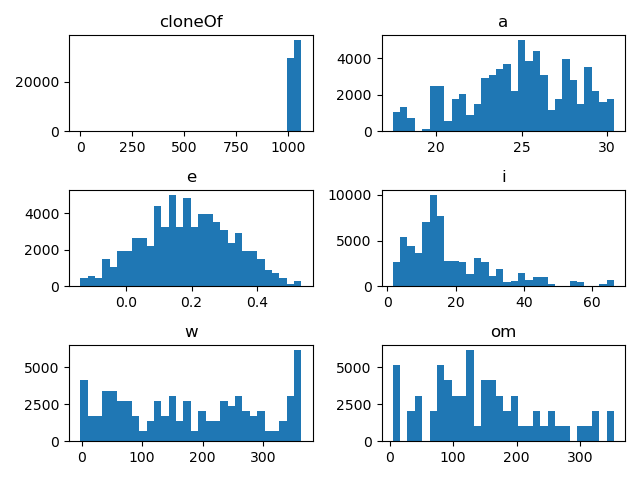

In [57]:
fig, ax = plt.subplots(nrows=3, ncols=2)
col_point=0
for row in ax:
    for col in row:
        col.hist(cloned_centaurs[cloned_centaurs.columns[col_point]], bins=30)
        col.set_title(cloned_centaurs.columns[col_point])
        col_point += 1
        
plt.tight_layout()

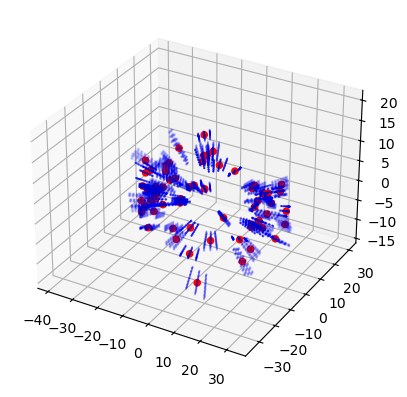

In [7]:
CartCentaurs = pd.read_csv("Data/CentaursCartesian.csv", index_col=0)

# Filter based on the condition
originals = CartCentaurs[CartCentaurs['cloneOf'] < 1000]
clones = CartCentaurs[CartCentaurs['cloneOf'] >= 1000]

# Create the 3D plot
fig = plt.figure()
ax = plt.axes(projection='3d')

# Plot the nodes with different sizes and colors
ax.scatter3D(clones['x'], clones['y'], clones['z'], s=0.1, c='b', alpha=0.05)  # Smaller nodes (blue)
ax.scatter3D(originals['x'], originals['y'], originals['z'], s=20, c='r', alpha=1)  # Larger nodes (red)

plt.show()

In [8]:
startPositionsAsteroids = pd.read_csv("Data/CentaursCartesian.csv", header=0, index_col=0)

In [11]:
startPositionsAsteroids.head

<bound method NDFrame.head of                 x             y             z            Vx            Vy  \
0   -9.198188e+11 -4.677037e+11  6.649661e+11    349.809100  -1107.474065   
1    2.247917e+12  1.442861e+12 -1.169936e+11  -3772.016473   3043.333107   
2   -1.217729e+12 -2.814734e+12 -1.039402e+12   3040.621932  -5383.118235   
3   -5.116365e+10  2.332616e+11 -1.967233e+11 -17166.859928  -2480.434259   
4   -1.593764e+12  2.386387e+12 -2.239876e+11   3472.335135   6627.997698   
..            ...           ...           ...           ...           ...   
899 -4.150288e+10  1.256054e+12  1.113762e+11 -10927.307035  -1751.101591   
900  2.681989e+11  1.525618e+10 -1.539452e+11  -3428.344188 -27158.573207   
901 -2.171181e+10 -3.692591e+11 -5.711134e+11 -11794.060001   8251.722115   
902 -5.540522e+11 -2.109008e+11 -2.704349e+11  -8573.762071  14045.375326   
903 -7.827660e+11 -4.078136e+11 -2.715647e+10  -6323.846256  12420.624417   

               Vz  
0     7745.497253  
1    